In [1]:
#import SQL library
import pyodbc
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.ticker as ticker
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [3]:
#pull RESELLER data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[RESELLER_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [4]:
dataset = pythonSQLobject

In [5]:
dataset.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,2024.994,Southeast
1,2011-05-31,6074.982,Southeast
2,2011-05-31,2024.994,Southeast
3,2011-05-31,2039.994,Southeast
4,2011-05-31,2039.994,Southeast


In [6]:
dataset.shape

(60919, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60919 entries, 0 to 60918
Data columns (total 3 columns):
OrderDate         60919 non-null datetime64[ns]
Revenue           60919 non-null float64
Territory_Name    60919 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


# Time Series Modeling with Prophet
## Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running

In [120]:
SE = dataset.loc[dataset['Territory_Name'] == 'Southeast']
SW = dataset.loc[dataset['Territory_Name'] == 'Southwest']
C = dataset.loc[dataset['Territory_Name'] == 'Central']
SE.shape, SW.shape, C.shape

((5937, 3), (13379, 3), (5812, 3))

In [121]:
SW

,OrderDate,Revenue,Territory_Name
51,2011-05-31,419.4589,Southwest
70,2011-05-31,419.4589,Southwest
71,2011-05-31,2146.9620,Southwest
72,2011-05-31,356.8980,Southwest
73,2011-05-31,874.7940,Southwest
...,...,...,...
60914,2014-05-01,316.8600,Southwest
60915,2014-05-01,809.7600,Southwest
60916,2014-05-01,3274.8000,Southwest
60917,2014-05-01,97.1820,Southwest


In [122]:
SE

,OrderDate,Revenue,Territory_Name
0,2011-05-31,2024.994,Southeast
1,2011-05-31,6074.982,Southeast
2,2011-05-31,2024.994,Southeast
3,2011-05-31,2039.994,Southeast
4,2011-05-31,2039.994,Southeast
...,...,...,...
60873,2014-05-01,2753.988,Southeast
60874,2014-05-01,125.982,Southeast
60875,2014-05-01,251.964,Southeast
60876,2014-05-01,125.982,Southeast


In [123]:
SE['OrderDate'] =  pd.to_datetime(SE['OrderDate'], format='%Y/%m')
SE = SE.sort_values(by=['OrderDate'], ascending=[True])
SE.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

SW['OrderDate'] =  pd.to_datetime(SW['OrderDate'], format='%Y/%m')
SW = SW.sort_values(by=['OrderDate'], ascending=[True])
SW.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

C['OrderDate'] =  pd.to_datetime(C['OrderDate'], format='%Y/%m')
C = C.sort_values(by=['OrderDate'], ascending=[True])
C.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

SE.drop(["Territory_Name"],axis=1, inplace=True)
SW.drop(["Territory_Name"],axis=1, inplace=True)
C.drop(["Territory_Name"],axis=1, inplace=True)

In [124]:
SW

,Revenue
OrderDate,
2011-05-31,419.4589
2011-05-31,367.8764
2011-05-31,6998.3520
2011-05-31,183.9382
2011-05-31,2097.2945
...,...
2014-05-01,12.1440
2014-05-01,9.5400
2014-05-01,890.8200


In [125]:
#y = df.resample('MS').mean()
y_SE = SE.resample('MS').sum()
y_SW = SW.resample('MS').sum()
z_C = C.resample('MS').sum()

In [126]:
y_SW

,Revenue
OrderDate,
2011-05-01,1.000564e+05
2011-06-01,0.000000e+00
2011-07-01,2.991821e+05
2011-08-01,5.460237e+05
2011-09-01,0.000000e+00
2011-10-01,9.483157e+05
2011-11-01,0.000000e+00
2011-12-01,1.161828e+05
2012-01-01,8.938620e+05


In [127]:
y_SE

,Revenue
OrderDate,
2011-05-01,139164.194300
2011-06-01,0.000000
2011-07-01,301907.491400
2011-08-01,308747.944700
2011-09-01,0.000000
2011-10-01,699101.881968
2011-11-01,0.000000
2011-12-01,191468.495900
2012-01-01,479416.517900


In [128]:
# filling up by mean value
y_SE = y_SE['Revenue'].replace(0.000000, y_SE['Revenue'].median())
y_SW = y_SW['Revenue'].replace(0.000000, y_SW['Revenue'].mean())
z_C = z_C['Revenue'].replace(0.000000, z_C['Revenue'].mean())

In [129]:
SE = pd.DataFrame({'OrderDate': y_SE.index, 'Revenue': y_SE.values})
SW = pd.DataFrame({'OrderDate': y_SW.index, 'Revenue': y_SW.values})
C = pd.DataFrame({'OrderDate': z_C.index, 'Revenue': z_C.values})

In [130]:
store = SE.merge(SW,how='inner', on='OrderDate')
store.rename(columns={'Revenue_x': 'SE_revenue', 'Revenue_y': 'SW_revenue'}, inplace=True)
store.head()

,OrderDate,SE_revenue,SW_revenue
0,2011-05-01,139164.194300,100056.433500
1,2011-06-01,207018.723617,499093.480773
2,2011-07-01,301907.491400,299182.145800
3,2011-08-01,308747.944700,546023.699100
4,2011-09-01,207018.723617,499093.480773


In [131]:
store

,OrderDate,SE_revenue,SW_revenue
0,2011-05-01,139164.194300,1.000564e+05
1,2011-06-01,207018.723617,4.990935e+05
2,2011-07-01,301907.491400,2.991821e+05
3,2011-08-01,308747.944700,5.460237e+05
4,2011-09-01,207018.723617,4.990935e+05
5,2011-10-01,699101.881968,9.483157e+05
6,2011-11-01,207018.723617,4.990935e+05
7,2011-12-01,191468.495900,1.161828e+05
8,2012-01-01,479416.517900,8.938620e+05
9,2012-02-01,246363.244400,1.301641e+05


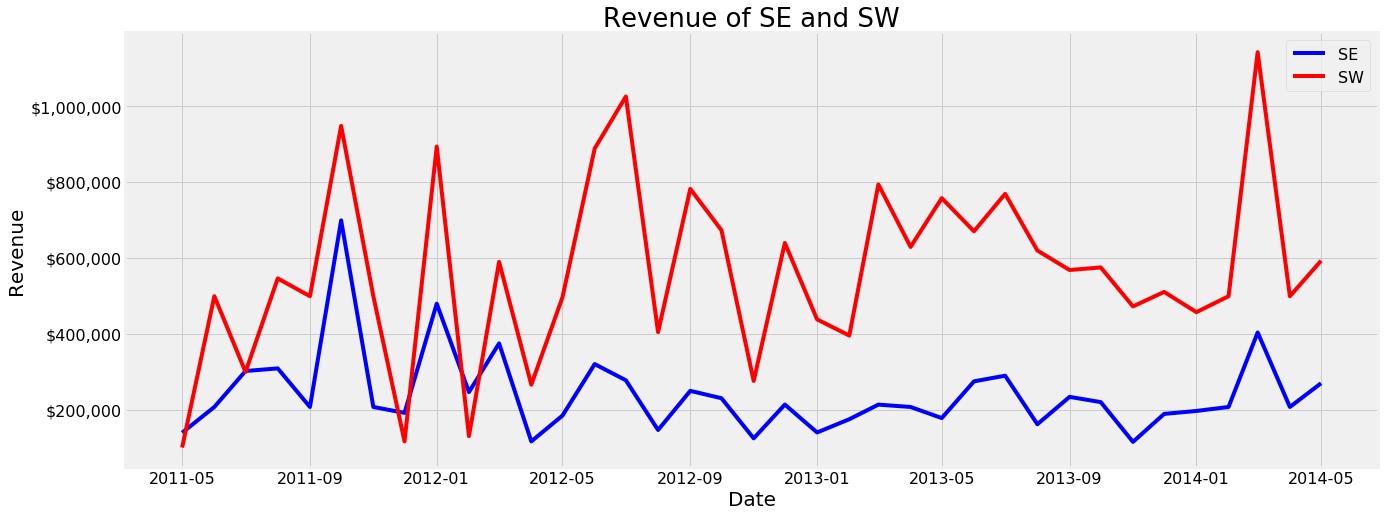

In [132]:
plt.figure(figsize=(20, 8))
plt.plot(store['OrderDate'], store['SE_revenue'], 'b-', label = 'SE')
plt.plot(store['OrderDate'], store['SW_revenue'], 'r-', label = 'SW')
plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Revenue of SE and SW')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.legend();

# Fitt Model with Prophet

In [149]:
from fbprophet import Prophet
SE = SE.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
SE_model = Prophet(interval_width=0.95)
SE_model.fit(SE)

SW = SW.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
SW_model = Prophet(interval_width=0.95)
SW_model.fit(SW)

C = C.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
C_model = Prophet(interval_width=0.95)
C_model.fit(C)

SE_forecast = SE_model.make_future_dataframe(periods=12, freq='MS')
SE_forecast = SE_model.predict(SE_forecast)

SW_forecast = SW_model.make_future_dataframe(periods=60, freq='MS')
SW_forecast = SW_model.predict(SW_forecast)

C_forecast = C_model.make_future_dataframe(periods=60, freq='MS')
C_forecast = C_model.predict(C_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


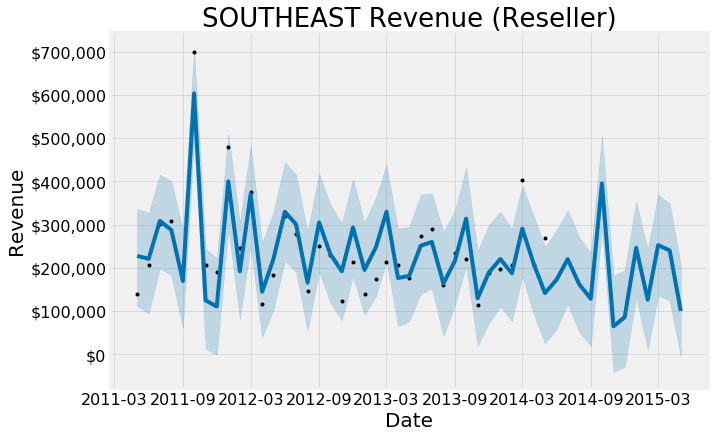

In [150]:
#plt.figure(figsize=(35,20))
plt.rc('font', size=SMALL_SIZE)
SE_model.plot(SE_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('SOUTHEAST Revenue (Reseller)');

<Figure size 2016x864 with 0 Axes>

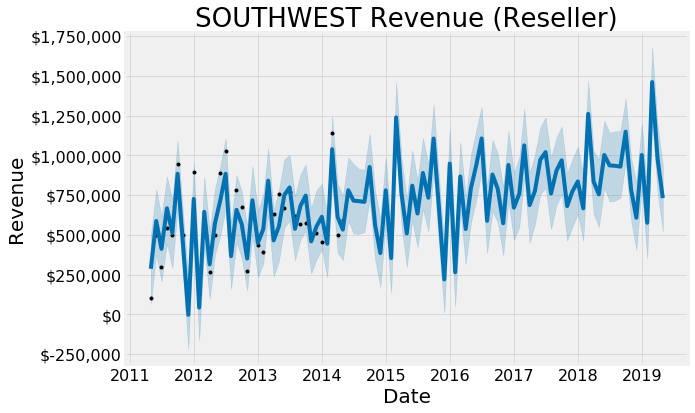

In [147]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
SW_model.plot(SW_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('SOUTHWEST Revenue (Reseller)');

<Figure size 2016x864 with 0 Axes>

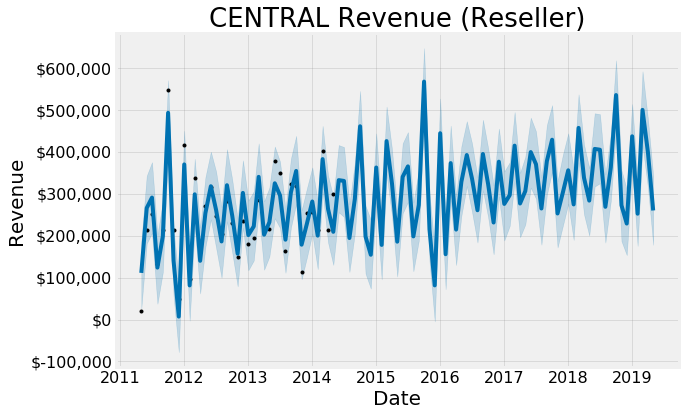

In [140]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
C_model.plot(C_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CENTRAL Revenue (Reseller)');

# Compare Forecasts
We already have the forecasts for three years for these two Teritory into the future. We will now join them together to compare their future forecasts.

In [151]:
SE_names = ['SE_%s' % column for column in SE_forecast.columns]
SW_names = ['SW_%s' % column for column in SW_forecast.columns]
C_names = ['DE_%s' % column for column in C_forecast.columns]

merge_SE_forecast = SE_forecast.copy()
merge_SW_forecast = SW_forecast.copy()
merge_C_forecast = C_forecast.copy()

merge_SE_forecast.columns = SE_names
merge_SW_forecast.columns = SW_names
merge_C_forecast.columns = C_names


forecast = pd.merge(merge_SE_forecast, merge_SW_forecast, how = 'inner', left_on = 'SE_ds', right_on = 'SW_ds')
forecast = forecast.rename(columns={'SE_ds': 'Date'}).drop('SW_ds', axis=1)
forecast.head()

,Date,SE_trend,SE_yhat_lower,SE_yhat_upper,SE_trend_lower,SE_trend_upper,SE_additive_terms,SE_additive_terms_lower,SE_additive_terms_upper,SE_yearly,...,SW_additive_terms,SW_additive_terms_lower,SW_additive_terms_upper,SW_yearly,SW_yearly_lower,SW_yearly_upper,SW_multiplicative_terms,SW_multiplicative_terms_lower,SW_multiplicative_terms_upper,SW_yhat
0,2011-05-01,276089.793958,112410.057542,336628.498377,276089.793958,276089.793958,-48334.476900,-48334.476900,-48334.476900,-48334.476900,...,-161516.322205,-161516.322205,-161516.322205,-161516.322205,-161516.322205,-161516.322205,0.0,0.0,0.0,286926.589600
1,2011-06-01,273370.851798,94909.661374,327104.890146,273370.851798,273370.851798,-52430.103026,-52430.103026,-52430.103026,-52430.103026,...,134200.191229,134200.191229,134200.191229,134200.191229,134200.191229,134200.191229,0.0,0.0,0.0,587353.723663
2,2011-07-01,270739.617446,198889.614897,415310.626928,270739.617446,270739.617446,37867.938731,37867.938731,37867.938731,37867.938731,...,-45574.304666,-45574.304666,-45574.304666,-45574.304666,-45574.304666,-45574.304666,0.0,0.0,0.0,412137.892925
3,2011-08-01,268020.675285,182625.756598,400548.907298,268020.675285,268020.675285,19485.862206,19485.862206,19485.862206,19485.862206,...,204447.620101,204447.620101,204447.620101,204447.620101,204447.620101,204447.620101,0.0,0.0,0.0,666870.438262
4,2011-09-01,265301.733121,61586.318587,285790.700467,265301.733121,265301.733121,-95750.235072,-95750.235072,-95750.235072,-95750.235072,...,44382.030199,44382.030199,44382.030199,44382.030199,44382.030199,44382.030199,0.0,0.0,0.0,511515.468930


# Trend and Forecast Visualization

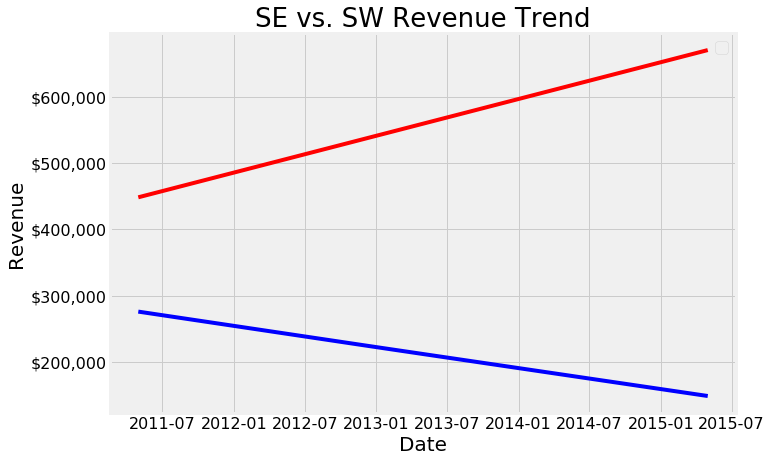

In [152]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['SE_trend'], 'b-')
plt.plot(forecast['Date'], forecast['SW_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('SE vs. SW Revenue Trend');

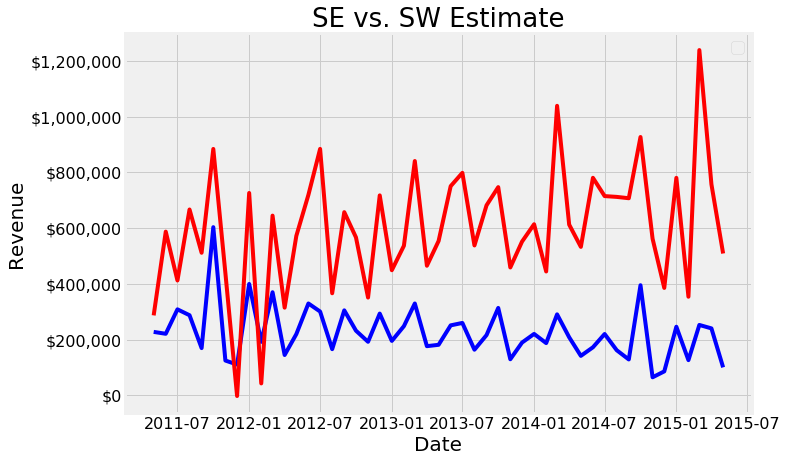

In [153]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['SE_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['SW_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('SE vs. SW Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two Teritory in the data.

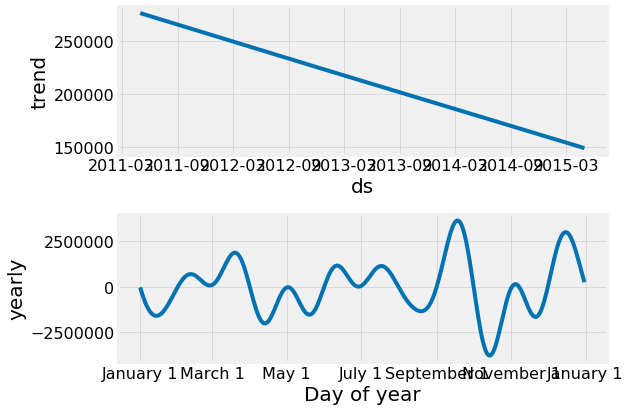

In [154]:
SE_model.plot_components(SE_forecast);

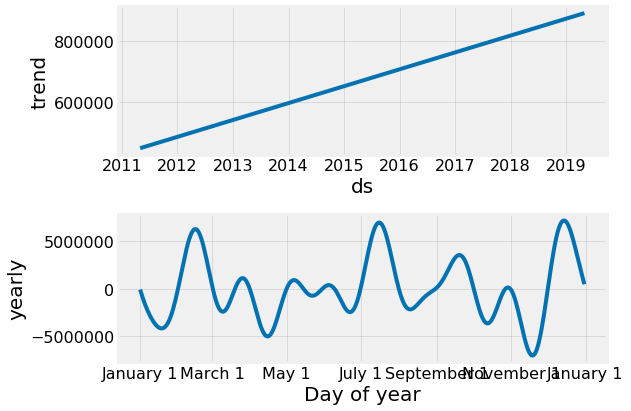

In [155]:
SW_model.plot_components(SW_forecast);

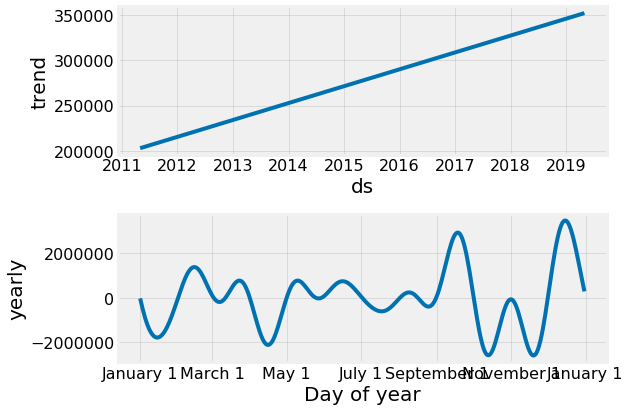

In [156]:
C_model.plot_components(C_forecast);

Good to see that the revenue for both Southwest and Central have been linearly increasing over time and will be keep growing, although Southeast’ growth seems downward.
The worst month for southeasr  is October, the worst month for Southwest is November. The best month for Southeast is September, and the best month for Southwest is December.
There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.